In [1]:
%load_ext autoreload
%autoreload 2

import glob
import os
import pynwb
import graph
from tqdm import tqdm
from pathlib import Path 
from datetime import datetime

import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LassoCV
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

import matplotlib
import matplotlib.pyplot as plt
# from matplotlib_venn import venn2
import seaborn as sns

In [2]:
sz1 = 16
sz2 = 18
sz3 = 12
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
matplotlib.rc('xtick', labelsize=sz1) 
matplotlib.rc('ytick', labelsize=sz1) 
matplotlib.rc('axes', labelsize=sz1)  
matplotlib.rc('axes', titlesize=sz1)  
matplotlib.rc('figure', titlesize=sz2)
matplotlib.rc('legend', fontsize=sz3) 
matplotlib.rc('legend', title_fontsize=sz1)
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

In [3]:
def initiate_directory(animal, date):  # region, epoch, query

    # wrapper to easily fetch data from one session
    
    # combine all sessions
    if animal=='London':
        
        DATA_DIR = Path('D:/Teleworld/london/neural')
        FIG_DIR = Path('D:/Figures/London')

        
    if animal=='Bart':
        
        FIG_DIR = Path('D:/Figures/Bart')
        
        if datetime.strptime(date, "%m%d%y")<datetime.strptime('050824', "%m%d%y"):
            DATA_DIR = Path('D:/Teleworld/bart_I/processed')
        else:
            DATA_DIR = Path('D:/Teleworld/bart_I/npx') 

    return DATA_DIR, FIG_DIR

In [4]:
def load_beh_neural(animal, date, region, epoch, query):

    # wrapper to easily fetch data from one session
    
    DATA_DIR, _ = initiate_directory(animal, date)
    os.chdir(DATA_DIR)
    
    filename = glob.glob('*%s*' % date) # sorted()
    nwbfile = pynwb.NWBHDF5IO(filename[0], "r").read()
    
    spikes, df, unitNames = get_spike_table(nwbfile, region, epoch, query=query)
    df.insert(0,'Session',date)
    unitNames.insert(0,'Session',date)
    unitNames.insert(0,'Animal',animal)
    
    return spikes, df, unitNames

In [5]:
def get_spike_table(nwbfile, region, epoch, query="", window_size=0, unit_params = {"drift": 2, "min_fr": 1}):
    
    """_summary_
    Returns:
        (np.array, pd.DataFrame) : spike table aligned to the specified epoch, dataframe with step metadata
        
    """
    
    assert epoch in nwbfile.intervals.keys(), f"Epoch {epoch} not found in nwbfile intervals. Available epochs: {nwbfile.intervals.keys()}"
    
    assert region in ["HPC", "OFC"], f"Region {region} not found. Available regions: ['HPC', 'OFC']"

    
    unitNames = nwbfile.units.to_dataframe()
    
    # get all good units
    unit_idx = np.where((unitNames.region == region) & (unitNames.group == "good") & (unitNames.drift <= unit_params["drift"]) & (unitNames.fr >= unit_params["min_fr"]))[0]
    unitNames = unitNames.iloc[unit_idx, :].reset_index(drop=True)

    
    # subsample an epoch with a specific query
    if query == "":
        df = nwbfile.intervals[epoch].to_dataframe()#["timeseries"]
    else:
        df = nwbfile.intervals[epoch].to_dataframe().query(query)#["timeseries"]

    neural_timeseries_index = 0
    sample_index = df.index
    
    if epoch!='fixations':        
        epoch_win_size = df["window_size"].values[0]
        spikes = np.zeros((len(sample_index), epoch_win_size*2, len(unit_idx)), dtype=np.float32)
        print("Building Spike Table")
        if window_size != 0:
            for i, _sample in tqdm(enumerate(sample_index)):
                sample_data = df["timeseries"][_sample][neural_timeseries_index].data[:, unit_idx]
                sample_data = movmean(sample_data.T, window_size).T
                spikes[i, ...] = sample_data.reshape(1, epoch_win_size*2, -1)
        else:
            for i, _sample in tqdm(enumerate(sample_index)):
                sample_data = df["timeseries"][_sample][neural_timeseries_index].data[:, unit_idx]
                spikes[i, ...] = sample_data.reshape(1, epoch_win_size*2, -1)
    

    if epoch=='fixations':
        
        spikes = np.zeros((len(df), len(unit_idx)), dtype=np.float32)
        
        for i, _sample in tqdm(enumerate(sample_index)):
            sample_data = df["timeseries"][_sample][neural_timeseries_index].data[:, unit_idx]
            spikes[i,:] = sample_data.mean(axis=0)
        
        df['planning'] = (df.duration<300) & (df.active_prob<0.2)
        df['choice'] = (df.duration>300) & (df.active_prob>0.2)
    
    df = graph.append_use_tele(df)
    df = df.drop(columns=["timeseries"])
    
    return spikes, df, unitNames

In [6]:
def partial_f_test(full_regressor, reduced_regressor, y):

    """F = ((RSSreduced – RSSfull)/p)  /  (RSSfull/n-k)
    
    where:
    
    RSSreduced: The residual sum of squares of the reduced (i.e. “nested”) model.
    RSSfull: The residual sum of squares of the full model.
    p: The number of predictors removed from the full model.
    n: The total observations in the dataset.
    k: The number of coefficients (including the intercept) in the full model.
    """

    df1 = full_regressor.shape[1]-reduced_regressor.shape[1]
    df2 = full_regressor.shape[0]-full_regressor.shape[1]

    # partial F-test
    full_model = sm.OLS(y, full_regressor).fit()
    reduced_model = sm.OLS(y, reduced_regressor).fit()
                
    fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
    pval = 1 - stats.f.cdf(fval, df1, df2)

    return fval, pval

In [7]:
def cv_ftest(res, X, y):

    # cross validated ftest to see if value or target node can be generalized across targets
    
    y_pred = np.matmul(X,res.params)
    SSE = np.sum(np.square(y.ravel()-y_pred))
    SSR = np.sum(np.square(y.mean()-y_pred))
    df1 = X.shape[1]-1
    df2 = X.shape[0]-X.shape[1]
    fval = (SSR/df1) / (SSE/df2)
    pval = 1 - stats.f.cdf(fval, df1, df2)

    return pval

In [8]:
def node_regression(ses, FR, timestamps, ws=100):

    # regression analysis with partial F-test, DON'T CHANGE THIS!!!
    # use node with maximum FR as a reference, k-1 dummies, add constant
    # regressors: 1) distance/value, 2) node as one hop vector
        
    enc = OneHotEncoder(sparse_output=False)
    one_hot_node = enc.fit_transform(ses['node'].values.reshape(-1,1))
    
    coef = np.ones((FR.shape[2],len(timestamps),one_hot_node.shape[1]+2))*np.nan
    pval = np.ones((FR.shape[2],len(timestamps),one_hot_node.shape[1]+2))*np.nan
    ref_node = np.ones((FR.shape[2],len(timestamps)))
    p_node = np.ones((FR.shape[2],len(timestamps)))*np.nan
    generic_target = np.ones((FR.shape[2],len(timestamps),4))*np.nan
    generic_value = np.ones((FR.shape[2],len(timestamps),4))*np.nan
    
    ses.loc[ses.graph_distance>2,'graph_distance']=3
    
    for nn in tqdm(range(FR.shape[2])):
                
        for ii, tt in enumerate(timestamps):
        
            # Fit the model
            y = FR[:,tt-ws:tt+ws,nn].mean(axis=1).reshape(-1,1)*1000
    
            # get regression coefficients for each node and value that are not reference
            # therefore, pvalue for each node means whether it is significantly different from the reference node
            # as indication of how selective to reference node
            
            lambda_i = np.array([y[ses.node.values == g].mean() for g in range(16)])
            ref = np.argmax(lambda_i)
    
            X = np.concatenate([ses['graph_distance'].values.reshape(-1,1),np.delete(one_hot_node,ref,axis=1)], axis=1)
            X = add_constant(X)
                    
            model = sm.OLS(y,X).fit()
            
            
            coef[nn,ii,:2] = model.params[:2]  # 1st is constant, 2nd is value, from 3rd are nodes
            pval[nn,ii,:2] = model.pvalues[:2]
            ref_node[nn,ii] = ref  

            # since there is no coef for reference node, leave it blank (np.nan)
            node_idx = 2+np.where(np.arange(16)!=ref)[0]
            coef[nn,ii,node_idx] = model.params[2:]
            pval[nn,ii,node_idx] = model.pvalues[2:]
    
            
            # see if the neuron shows any node/spatial tuning with partial F-test
            X_reduced = add_constant(ses['graph_distance'].values.reshape(-1,1))
            _, p_node[nn,ii] = partial_f_test(X, X_reduced, y)


            # generic target coding, using cross validated f-test
            all_target = np.isin(ses.node,[1,7,8,14])
            
            for jj, target in enumerate([1,7,8,14]):
                    
                test_target = ses.node.values==target
                # remove test target from training set
                model = sm.OLS(y[~test_target,:],X[~test_target,:]).fit()    
                
                # combine non target indices with test target indices
                test_idx = np.concat([np.where(~all_target)[0], np.where(test_target)[0]])
                generic_target[nn,ii,jj] = cv_ftest(model, X[test_idx,:], y[test_idx,:])

                
            # generic value coding, using cross validated f-test
            X = add_constant(ses['graph_distance'].values)
                
            for jj, target in enumerate([1,7,8,14]):
                
                idx = ses.target.values==target
                model = sm.OLS(y[~idx,:],X[~idx,:]).fit()        
                generic_value[nn,ii,jj] = cv_ftest(model, X[idx,:], y[idx,:])

    return coef, pval, ref_node, p_node, generic_target, generic_value

In [33]:
def step_regression(ses, FR, timestamps, ws=100):

    # regression analysis with partial F-test, DON'T CHANGE THIS!!!
    # use node with maximum FR as a reference, k-1 dummies, add constant
    # regressors: 1) distance/value, 2) node as one hop vector
        
    enc = OneHotEncoder(sparse_output=False)
    one_hot_node = enc.fit_transform(ses['step'].values.reshape(-1,1))
    
    coef = np.ones((FR.shape[2],len(timestamps),one_hot_node.shape[1]+2))*np.nan
    pval = np.ones((FR.shape[2],len(timestamps),one_hot_node.shape[1]+2))*np.nan
    ref_node = np.ones((FR.shape[2],len(timestamps)))
    p_node = np.ones((FR.shape[2],len(timestamps)))*np.nan
    
    ses.loc[ses.graph_distance>2,'graph_distance']=3
    
    for nn in tqdm(range(FR.shape[2])):
                
        for ii, tt in enumerate(timestamps):
        
            # Fit the model
            y = FR[:,tt-ws:tt+ws,nn].mean(axis=1).reshape(-1,1)*1000
    
            # get regression coefficients for each node and value that are not reference
            # therefore, pvalue for each node means whether it is significantly different from the reference node
            # as indication of how selective to reference node
            
            lambda_i = np.array([y[ses.step.values == g].mean() for g in range(5)])
            ref = np.argmax(lambda_i)
    
            X = np.concatenate([ses['graph_distance'].values.reshape(-1,1),np.delete(one_hot_node,ref,axis=1)], axis=1)
            X = add_constant(X)
                    
            model = sm.OLS(y,X).fit()
            
            
            coef[nn,ii,:2] = model.params[:2]  # 1st is constant, 2nd is value, from 3rd are nodes
            pval[nn,ii,:2] = model.pvalues[:2]
            ref_node[nn,ii] = ref  

            # since there is no coef for reference node, leave it blank (np.nan)
            node_idx = 2+np.where(np.arange(5)!=ref)[0]
            coef[nn,ii,node_idx] = model.params[2:]
            pval[nn,ii,node_idx] = model.pvalues[2:]
    
            
            # see if the neuron shows any node/spatial tuning with partial F-test
            X_reduced = add_constant(ses['graph_distance'].values.reshape(-1,1))
            _, p_node[nn,ii] = partial_f_test(X, X_reduced, y)


    return coef, pval, ref_node, p_node

In [20]:
def target_node_regression(ses, FR, timestamps, ws=100):

    # regression analysis with partial F-test, DON'T CHANGE THIS!!!
    # use node with maximum FR as a reference, k-1 dummies, add constant
    # regressors: 1) distance/value, 2) node as one hop vector
        
    enc = OneHotEncoder(sparse_output=False)
    one_hot_node = enc.fit_transform(ses['node'].values.reshape(-1,1))
    
    coef = np.ones((FR.shape[2],len(timestamps),one_hot_node.shape[1]+1))*np.nan
    pval = np.ones((FR.shape[2],len(timestamps),one_hot_node.shape[1]+1))*np.nan
    ref_node = np.ones((FR.shape[2],len(timestamps)))
    p_node = np.ones((FR.shape[2],len(timestamps)))*np.nan
        
    for nn in tqdm(range(FR.shape[2])):
                
        for ii, tt in enumerate(timestamps):
        
            # Fit the model
            y = FR[:,tt-ws:tt+ws,nn].mean(axis=1).reshape(-1,1)*1000
    
            # get regression coefficients for each node and value that are not reference
            # therefore, pvalue for each node means whether it is significantly different from the reference node
            # as indication of how selective to reference node
            
            lambda_i = np.array([y[ses.node.values == g].mean() for g in [1,7,8,14]])
            ref = np.argmax(lambda_i)
            
            X = add_constant(np.delete(one_hot_node,ref,axis=1))
                    
            model = sm.OLS(y,X).fit()
            
            coef[nn,ii,0] = model.params[0]  # 1st is constant, 2nd is value, from 3rd are nodes
            pval[nn,ii,0] = model.pvalues[0]
            ref_node[nn,ii] = ref  
            
            # since there is no coef for reference node, leave it blank (np.nan)
            node_idx = 1+np.where(np.arange(4)!=ref)[0]
            coef[nn,ii,node_idx] = model.params[1:]
            pval[nn,ii,node_idx] = model.pvalues[1:]
    
            # see if the neuron shows any node/spatial tuning with partial F-test
            X_reduced = np.ones((X.shape[0],1))
            _, p_node[nn,ii] = partial_f_test(X, X_reduced, y)

    
    return coef, pval, ref_node, p_node

In [10]:
def target_regression(ses, FR, timestamps, ws=100):

    # regression analysis with partial F-test, DON'T CHANGE THIS!!!
    # use node with maximum FR as a reference, k-1 dummies, add constant
    # regressors: 1) distance/value, 2) node as one hop vector
        
    enc = OneHotEncoder(sparse_output=False)
    one_hot_node = enc.fit_transform(ses['target'].values.reshape(-1,1))
    
    coef = np.ones((FR.shape[2],len(timestamps),one_hot_node.shape[1]+1))*np.nan
    pval = np.ones((FR.shape[2],len(timestamps),one_hot_node.shape[1]+1))*np.nan
    ref_node = np.ones((FR.shape[2],len(timestamps)))
    p_node = np.ones((FR.shape[2],len(timestamps)))*np.nan
        
    for nn in tqdm(range(FR.shape[2])):
                
        for ii, tt in enumerate(timestamps):
        
            # Fit the model
            y = FR[:,tt-ws:tt+ws,nn].mean(axis=1).reshape(-1,1)*1000
    
            # get regression coefficients for each node and value that are not reference
            # therefore, pvalue for each node means whether it is significantly different from the reference node
            # as indication of how selective to reference node
            
            lambda_i = np.array([y[ses.target.values == g].mean() for g in [1,7,8,14]])
            ref = np.argmax(lambda_i)
            
            X = add_constant(np.delete(one_hot_node,ref,axis=1))
                    
            model = sm.OLS(y,X).fit()
            
            coef[nn,ii,0] = model.params[0]  # 1st is constant
            pval[nn,ii,0] = model.pvalues[0]
            ref_node[nn,ii] = ref  
            
            # since there is no coef for reference node, leave it blank (np.nan)
            node_idx = 1+np.where(np.arange(4)!=ref)[0]
            coef[nn,ii,node_idx] = model.params[1:]
            pval[nn,ii,node_idx] = model.pvalues[1:]
    
            # see if the neuron shows any node/spatial tuning with partial F-test
            X_reduced = np.ones((X.shape[0],1))
            _, p_node[nn,ii] = partial_f_test(X, X_reduced, y)

    
    return coef, pval, ref_node, p_node

In [11]:
ses_info = {'session':['031723','032823','033123','032023','040423','040723','050824',  # Bart
               '101124', '100324', '092124', '092324', '092524', '100124','100924'],
           'animal': ['Bart']*7+['London']*7}
all_sessions = pd.DataFrame(ses_info)  # London

In [116]:
# compare the tuning across three conditions.
# 1) flash trial: current node
# 2) navigation trial, first step only at target nodes: current node
# 3) navigation trial, center nodes: current target
# 4) nav, center nodes, first step: current target
# 5) nav, all nodes, first step: current target

# look at tuning to the current target
# since target neurons respond strongly when the animals fixate on the corresponding nodes, exclude those steps
# more strictly, since the frequency of each node visited of a given target can be very biased, only restrict this analysis to center 4 nodes

neuron_df = pd.DataFrame()
coef_all = [[[],[],[]] for _ in range(len(all_sessions))] # [[] for _ in range(len(all_sessions))] for _ in range(5)
pval_all = [[[],[],[]] for _ in range(len(all_sessions))]
ref_node_all = [[[],[],[]] for _ in range(len(all_sessions))]
p_node_all = [[[],[],[]] for _ in range(len(all_sessions))]


for ii in range(len(all_sessions)):
    
    session = all_sessions.iloc[ii].session
    animal = all_sessions.iloc[ii].animal
    print(session)
    
    DATA_DIR, FIG_DIR = initiate_directory(animal, session)

    # flash trial: current node
    spikes, df, unitNames = load_beh_neural(animal, session, 'HPC','action_on','(trialerror==1)')
    coef, pval, ref_node, p_node = target_node_regression(df.copy(), spikes.copy(), np.arange(100,950,50), ws=100)
    
    coef_all[ii][0] = coef
    pval_all[ii][0] = pval
    ref_node_all[ii][0] = ref_node
    p_node_all[ii][0] = p_node

    
    # 2) navigation trial, first step only at target nodes: current node
    
    spikes, df, unitNames = load_beh_neural(animal, session, 'OFC','action_on','(trialerror==0) & (step==0)')
    idx = np.isin(df.node,[1,7,8,14])
    coef, pval, ref_node, p_node = target_node_regression(df[idx].copy(), spikes[idx,:,:].copy(), np.arange(100,950,50), ws=100)

    coef_all[ii][1] = coef
    pval_all[ii][1] = pval
    ref_node_all[ii][1] = ref_node
    p_node_all[ii][1] = p_node

    
    # 3) navigation trial, center nodes: current target

    spikes, df, unitNames = load_beh_neural(animal, session, 'OFC','action_on','(trialerror==0)')
    idx = np.isin(df.node,[5,6,9,10])
    coef, pval, ref_node, p_node = target_regression(df[idx].copy(), spikes[idx,:,:].copy(), np.arange(100,950,50), ws=100) 

    coef_all[ii][2] = coef
    pval_all[ii][2] = pval
    ref_node_all[ii][2] = ref_node
    p_node_all[ii][2] = p_node
    
    neuron_df = pd.concat([neuron_df,unitNames])


031723
Building Spike Table


228it [00:00, 3046.59it/s]
100%|██████████| 90/90 [00:02<00:00, 35.75it/s]


Building Spike Table


492it [00:00, 3058.16it/s]
C:\Users\ML_4\AppData\Local\Temp\ipykernel_17936\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
C:\Users\ML_4\AppData\Local\Temp\ipykernel_17936\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
C:\Users\ML_4\AppData\Local\Temp\ipykernel_17936\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
C:\Users\ML_4\AppData\Local\Temp\ipykernel_17936\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
C:\Users\ML_4\AppData\Local\Temp\ipykernel_17936\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_mod

Building Spike Table


1499it [00:00, 3106.34it/s]
100%|██████████| 90/90 [00:04<00:00, 18.12it/s]


032823
Building Spike Table


235it [00:00, 2624.81it/s]
100%|██████████| 136/136 [00:03<00:00, 36.42it/s]


Building Spike Table


553it [00:00, 2443.67it/s]
100%|██████████| 136/136 [00:03<00:00, 39.95it/s]


Building Spike Table


1860it [00:00, 2423.80it/s]
100%|██████████| 136/136 [00:07<00:00, 17.69it/s]


033123
Building Spike Table


252it [00:00, 3025.90it/s]
100%|██████████| 94/94 [00:04<00:00, 18.95it/s]


Building Spike Table


608it [00:00, 3819.46it/s]
100%|██████████| 94/94 [00:02<00:00, 41.75it/s]


Building Spike Table


2067it [00:00, 3731.76it/s]
100%|██████████| 94/94 [00:04<00:00, 19.02it/s]


032023
Building Spike Table


288it [00:00, 4447.58it/s]
100%|██████████| 72/72 [00:03<00:00, 19.25it/s]


Building Spike Table


712it [00:00, 4290.48it/s]
100%|██████████| 72/72 [00:01<00:00, 40.95it/s]


Building Spike Table


2278it [00:00, 4042.59it/s]
100%|██████████| 72/72 [00:04<00:00, 16.30it/s]


040423
Building Spike Table


294it [00:00, 3243.63it/s]
100%|██████████| 99/99 [00:05<00:00, 19.11it/s]


Building Spike Table


702it [00:00, 2912.96it/s]
100%|██████████| 99/99 [00:02<00:00, 35.67it/s]


Building Spike Table


2452it [00:00, 3232.02it/s]
100%|██████████| 99/99 [00:05<00:00, 17.55it/s]


040723
Building Spike Table


239it [00:00, 4130.50it/s]
100%|██████████| 81/81 [00:02<00:00, 34.04it/s]


Building Spike Table


596it [00:00, 3948.03it/s]
100%|██████████| 81/81 [00:01<00:00, 40.68it/s]


Building Spike Table


2093it [00:00, 4083.35it/s]
100%|██████████| 81/81 [00:04<00:00, 18.13it/s]


050824
Building Spike Table


146it [00:00, 1248.55it/s]
100%|██████████| 152/152 [00:04<00:00, 35.85it/s]


Building Spike Table


417it [00:00, 1491.24it/s]
C:\Users\ML_4\AppData\Local\Temp\ipykernel_17936\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
100%|██████████| 152/152 [00:03<00:00, 41.59it/s]


Building Spike Table


1383it [00:00, 1517.77it/s]
100%|██████████| 152/152 [00:08<00:00, 18.90it/s]


101124
Building Spike Table


190it [00:00, 1207.08it/s]
C:\Users\ML_4\AppData\Local\Temp\ipykernel_17936\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
C:\Users\ML_4\AppData\Local\Temp\ipykernel_17936\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
100%|██████████| 145/145 [00:04<00:00, 30.36it/s]


Building Spike Table


753it [00:00, 1194.26it/s]
C:\Users\ML_4\AppData\Local\Temp\ipykernel_17936\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
C:\Users\ML_4\AppData\Local\Temp\ipykernel_17936\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
C:\Users\ML_4\AppData\Local\Temp\ipykernel_17936\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
C:\Users\ML_4\AppData\Local\Temp\ipykernel_17936\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
C:\Users\ML_4\AppData\Local\Temp\ipykernel_17936\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_mod

Building Spike Table


2545it [00:02, 1255.15it/s]
100%|██████████| 145/145 [00:09<00:00, 14.71it/s]


100324
Building Spike Table


180it [00:00, 1587.75it/s]
100%|██████████| 113/113 [00:03<00:00, 32.82it/s]


Building Spike Table


713it [00:00, 1475.68it/s]
100%|██████████| 113/113 [00:03<00:00, 33.39it/s]


Building Spike Table


2417it [00:01, 1621.38it/s]
100%|██████████| 113/113 [00:07<00:00, 15.28it/s]


092124
Building Spike Table


180it [00:00, 1401.39it/s]
100%|██████████| 104/104 [00:03<00:00, 34.03it/s]


Building Spike Table


717it [00:00, 1473.80it/s]
C:\Users\ML_4\AppData\Local\Temp\ipykernel_17936\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
100%|██████████| 104/104 [00:03<00:00, 34.14it/s]


Building Spike Table


2401it [00:01, 1420.97it/s]
100%|██████████| 104/104 [00:06<00:00, 16.44it/s]


092324
Building Spike Table


180it [00:00, 1441.16it/s]
100%|██████████| 136/136 [00:03<00:00, 37.70it/s]


Building Spike Table


720it [00:00, 1251.03it/s]
100%|██████████| 136/136 [00:03<00:00, 37.26it/s]


Building Spike Table


2450it [00:01, 1518.88it/s]
100%|██████████| 136/136 [00:08<00:00, 16.41it/s]


092524
Building Spike Table


179it [00:00, 1419.29it/s]
C:\Users\ML_4\AppData\Local\Temp\ipykernel_17936\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
100%|██████████| 112/112 [00:03<00:00, 35.26it/s]


Building Spike Table


712it [00:00, 1508.65it/s]
C:\Users\ML_4\AppData\Local\Temp\ipykernel_17936\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
C:\Users\ML_4\AppData\Local\Temp\ipykernel_17936\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
100%|██████████| 112/112 [00:02<00:00, 40.35it/s]


Building Spike Table


2427it [00:01, 1606.36it/s]
100%|██████████| 112/112 [00:06<00:00, 17.09it/s]


100124
Building Spike Table


182it [00:00, 1359.50it/s]
100%|██████████| 91/91 [00:02<00:00, 36.91it/s]


Building Spike Table


728it [00:00, 1616.56it/s]
100%|██████████| 91/91 [00:02<00:00, 41.63it/s]


Building Spike Table


2432it [00:01, 1763.60it/s]
100%|██████████| 91/91 [00:05<00:00, 17.39it/s]


100924
Building Spike Table


182it [00:00, 1561.32it/s]
C:\Users\ML_4\AppData\Local\Temp\ipykernel_17936\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
100%|██████████| 97/97 [00:02<00:00, 38.02it/s]


Building Spike Table


728it [00:00, 1857.68it/s]
C:\Users\ML_4\AppData\Local\Temp\ipykernel_17936\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
C:\Users\ML_4\AppData\Local\Temp\ipykernel_17936\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
C:\Users\ML_4\AppData\Local\Temp\ipykernel_17936\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
C:\Users\ML_4\AppData\Local\Temp\ipykernel_17936\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
C:\Users\ML_4\AppData\Local\Temp\ipykernel_17936\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_mod

Building Spike Table


2434it [00:01, 1806.15it/s]
100%|██████████| 97/97 [00:05<00:00, 16.44it/s]


In [117]:
p_node_flash = []
p_node_nav0 = []
p_nav_target = []
ref_node_flash = []
ref_node_nav0 = []
ref_nav_target = []

for ii in range(len(all_sessions)):
    
    p_node_flash.append(p_node_all[ii][0])
    p_node_nav0.append(p_node_all[ii][1])
    p_nav_target.append(p_node_all[ii][2])
    
    ref_node_flash.append(ref_node_all[ii][0])
    ref_node_nav0.append(ref_node_all[ii][1])
    ref_nav_target.append(ref_node_all[ii][2])
    
p_node_flash = np.vstack(p_node_flash)
p_node_nav0 = np.vstack(p_node_nav0)
p_nav_target = np.vstack(p_nav_target)

ref_node_flash = np.vstack(ref_node_flash)
ref_node_nav0 = np.vstack(ref_node_nav0)
ref_nav_target = np.vstack(ref_nav_target)

In [118]:
alpha = 0.01
t_max = np.argmax(np.mean(p_node_flash<alpha,axis=0))
flash_sig = p_node_flash[:,t_max]<alpha
flash_ref = ref_node_flash[:,t_max] 

t_max = np.argmax(np.mean(p_node_nav0<alpha,axis=0))
nav0_sig = p_node_nav0[:,t_max] <alpha
nav0_ref = ref_node_nav0[:,t_max] 

t_max = np.argmax(np.mean(p_nav_target<alpha,axis=0))
navtarget_sig = p_nav_target[:,t_max] <alpha
navtarget_ref = ref_nav_target[:,t_max] 

In [114]:
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact, binomtest

def pairwise_table(flash_sig, nav0_sig, navtarget_sig,
                   flash_ref, nav0_ref, navtarget_ref):

    results = []

    # Helper to compute binomial & fisher
    def compute_tests(a, b):
        # 2x2 contingency table
        # A=1,B=1 ; A=1,B=0 ; A=0,B=1 ; A=0,B=0
        t11 = np.sum(a & b)
        t10 = np.sum(a & ~b)
        t01 = np.sum(~a & b)
        t00 = np.sum(~a & ~b)
        table = np.array([[t11, t10],
                          [t01, t00]])

        # --- Binomial test: co-occurrence (cell 1,1) ---
        # expected p = p(a=1)*p(b=1)
        p_a = np.mean(a)
        p_b = np.mean(b)
        p_expected = p_a * p_b
        bt = binomtest(k=t11, n=len(a), p=p_expected)

        # --- Fisher’s exact test ---
        ft = fisher_exact(table)

        return bt.pvalue, ft[1]

    # Helper to compute % same reference
    def ref_agreement(a, b, a_ref, b_ref):
        idx = a & b
        print(idx.sum())
        if np.sum(idx) == 0:
            return np.nan
        return np.mean(a_ref[idx] == b_ref[idx])*100

    # ------------------ 1. flash vs nav0 -------------------
    binom_p, fisher_p = compute_tests(flash_sig, nav0_sig)
    ref_same = ref_agreement(flash_sig, nav0_sig, flash_ref, nav0_ref)
    results.append(["flash vs nav0", binom_p, fisher_p, ref_same])

    # ------------------ 2. flash vs navtarget -------------------
    binom_p, fisher_p = compute_tests(flash_sig, navtarget_sig)
    ref_same = ref_agreement(flash_sig, navtarget_sig, flash_ref, navtarget_ref)
    results.append(["flash vs navtarget", binom_p, fisher_p, ref_same])

    # ------------------ 3. nav0 vs navtarget -------------------
    binom_p, fisher_p = compute_tests(nav0_sig, navtarget_sig)
    ref_same = ref_agreement(nav0_sig, navtarget_sig, nav0_ref, navtarget_ref)
    results.append(["nav0 vs navtarget", binom_p, fisher_p, ref_same])

    # Make table
    df = pd.DataFrame(results, columns=["Comparison", "Binomial p", "Fisher p", "Same ref %"])
    return df


# --------------------------------------------
# Example usage:
# table = pairwise_table(flash_sig, nav0_sig, navtarget_sig, flash_ref, nav0_ref, navtarget_ref)
# print(table)


In [120]:
table = pairwise_table(flash_sig, nav0_sig, navtarget_sig, flash_ref, nav0_ref, navtarget_ref)
table

105
50
43


,Comparison,Binomial p,Fisher p,Same ref %
0,flash vs nav0,1.502738e-26,1.302900e-42,79.047619
1,flash vs navtarget,1.496884e-03,2.136098e-04,24.000000
2,nav0 vs navtarget,8.397613e-06,2.226894e-07,20.930233


In [63]:
def binom(a,b):
    
    p_indepenend = a.mean()*b.mean()
    result = stats.binomtest(np.sum(a & b), len(a), p=p_indepenend, alternative='greater')

    print(a.mean(), b.mean(), np.mean(a&b))

    return result

In [69]:
from scipy.stats import fisher_exact

def fisher(A,B):
    
    AB = np.sum(A&B)
    A_ = np.sum(A)-AB
    B_ = np.sum(B)-AB
    AnotB = len(A)-A_-B_+AB
    
    res = fisher_exact([[AB, A_],[B_,AnotB]], alternative='two-sided')
    return res

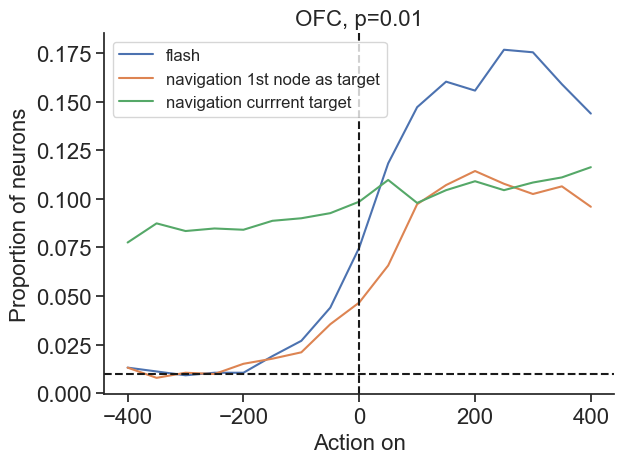

In [119]:
plt.close('all')
plt.plot(np.arange(100,950,50)-500,np.mean(p_node_flash<alpha,axis=0),label='flash')
plt.plot(np.arange(100,950,50)-500,np.mean(p_node_nav0<alpha,axis=0),label='navigation 1st node as target')
plt.plot(np.arange(100,950,50)-500,np.mean(p_nav_target<alpha,axis=0),label='navigation currrent target')
plt.legend()
plt.title('OFC, p=0.01')
plt.ylabel('Proportion of neurons')
plt.xlabel('Action on')
plt.axvline(0,color='k',ls='--')
plt.axhline(0.01,color='k',ls='--')
plt.tight_layout()
plt.savefig('OFC target node encoding')

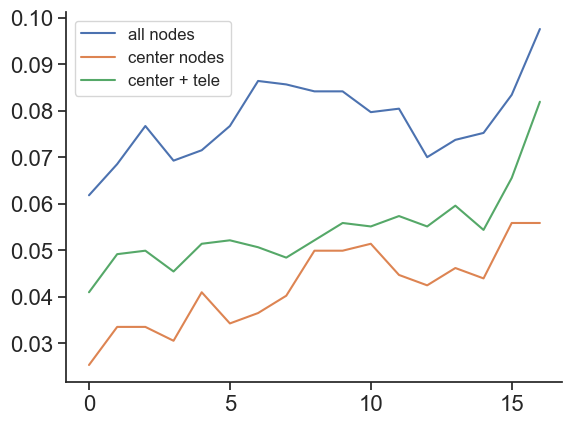

In [17]:
plt.close('all')
plt.plot(np.mean(np.vstack(p_node_all)<0.01,axis=0),label='all nodes')
plt.plot(np.mean(np.vstack(p_node_center)<0.01,axis=0),label='center nodes')
plt.plot(np.mean(np.vstack(p_node_center_tele)<0.01,axis=0),label='center + tele')
plt.legend()

In [16]:
# do regression on all recording sessions, navigation trials

neuron_df = pd.DataFrame()
coef_all = []
pval_all = []
ref_node_all = []
p_node_all = []
generic_target_all = []
generic_value_all = []

for ii in range(len(all_sessions)):
    
    session = all_sessions.iloc[ii].session
    animal = all_sessions.iloc[ii].animal
    print(session)
    
    DATA_DIR, FIG_DIR = initiate_directory(animal, session)
    spikes, df, unitNames = load_beh_neural(animal, session, 'HPC','action_on','(trialerror==0)')
    coef, pval, ref_node, p_node, generic_target, generic_value = node_regression(df.copy(), spikes.copy(), np.arange(100,950,50), ws=100)

    coef_all.append(coef)
    pval_all.append(pval)
    ref_node_all.append(ref_node)
    p_node_all.append(p_node)
    generic_target_all.append(generic_target)
    generic_value_all.append(generic_value)
    
    neuron_df = pd.concat([neuron_df,unitNames])

031723
Building Spike Table


228it [00:00, 3838.06it/s]
C:\Users\ML_4\AppData\Local\Temp\ipykernel_18304\947918252.py:30: RuntimeWarning: Mean of empty slice.
  lambda_i = np.array([y[ses.node.values == g].mean() for g in range(16)])
C:\Users\ML_4\anaconda3\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
  0%|          | 0/80 [00:00<?, ?it/s]


ValueError: shape mismatch: value array of shape (3,) could not be broadcast to indexing result of shape (15,)

In [85]:
# do regression on all recording sessions, flash trials

neuron_df = pd.DataFrame()
coef_all = []
pval_all = []
ref_node_all = []
p_node_all = []

for ii in range(len(all_sessions)):
    
    session = all_sessions.iloc[ii].session
    animal = all_sessions.iloc[ii].animal
    print(session)
    
    DATA_DIR, FIG_DIR = initiate_directory(animal, session)
    spikes, df, unitNames = load_beh_neural(animal, session, 'OFC','action_on','(trialerror==1)')
    coef, pval, ref_node, p_node = flash_node_regression(df.copy(), spikes.copy(), np.arange(100,950,50), ws=100)

    coef_all.append(coef)
    pval_all.append(pval)
    ref_node_all.append(ref_node)
    p_node_all.append(p_node)
    
    neuron_df = pd.concat([neuron_df,unitNames])

031723
Building Spike Table


228it [00:00, 3583.69it/s]
100%|██████████| 90/90 [00:02<00:00, 33.04it/s]


032823
Building Spike Table


235it [00:00, 2208.89it/s]
100%|██████████| 136/136 [00:04<00:00, 33.03it/s]


033123
Building Spike Table


252it [00:00, 3362.20it/s]
100%|██████████| 94/94 [00:04<00:00, 19.20it/s]


032023
Building Spike Table


288it [00:00, 3440.27it/s]
100%|██████████| 72/72 [00:03<00:00, 18.91it/s]


040423
Building Spike Table


294it [00:00, 3314.50it/s]
100%|██████████| 99/99 [00:05<00:00, 19.17it/s]


040723
Building Spike Table


239it [00:00, 3859.47it/s]
100%|██████████| 81/81 [00:02<00:00, 33.15it/s]


050824
Building Spike Table


146it [00:00, 1308.35it/s]
100%|██████████| 152/152 [00:04<00:00, 35.59it/s]


051024
Building Spike Table


130it [00:00, 1862.44it/s]
C:\Users\ML_4\AppData\Local\Temp\ipykernel_18304\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
C:\Users\ML_4\AppData\Local\Temp\ipykernel_18304\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
C:\Users\ML_4\AppData\Local\Temp\ipykernel_18304\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
C:\Users\ML_4\AppData\Local\Temp\ipykernel_18304\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
C:\Users\ML_4\AppData\Local\Temp\ipykernel_18304\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_mod

101124
Building Spike Table


190it [00:00, 1467.45it/s]
C:\Users\ML_4\AppData\Local\Temp\ipykernel_18304\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
C:\Users\ML_4\AppData\Local\Temp\ipykernel_18304\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
100%|██████████| 145/145 [00:04<00:00, 34.14it/s]


100324
Building Spike Table


180it [00:00, 1574.75it/s]
100%|██████████| 113/113 [00:03<00:00, 35.91it/s]


092124
Building Spike Table


180it [00:00, 1509.55it/s]
100%|██████████| 104/104 [00:02<00:00, 35.26it/s]


092324
Building Spike Table


180it [00:00, 1525.25it/s]
100%|██████████| 136/136 [00:03<00:00, 34.81it/s]


092524
Building Spike Table


179it [00:00, 1458.98it/s]
C:\Users\ML_4\AppData\Local\Temp\ipykernel_18304\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
100%|██████████| 112/112 [00:03<00:00, 35.15it/s]


100124
Building Spike Table


182it [00:00, 1735.07it/s]
100%|██████████| 91/91 [00:02<00:00, 34.44it/s]


100924
Building Spike Table


182it [00:00, 1920.21it/s]
C:\Users\ML_4\AppData\Local\Temp\ipykernel_18304\3288527834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fval = ((reduced_model.ssr-full_model.ssr)/df1)/(full_model.ssr/df2)
100%|██████████| 97/97 [00:02<00:00, 35.54it/s]


In [86]:
# add regression results to neuron_df, navigation trials

neuron_df["coef"] = list(np.vstack(coef_all)) 
neuron_df["pval"] = list(np.vstack(pval_all))
neuron_df["max_node_all"] = list(np.vstack(ref_node_all))
neuron_df['spatial_ftest_pval'] = list(np.vstack(p_node_all))

_, neuron_df["value"] = get_sig(np.vstack(pval_all)[:,:,1])
ts, neuron_df['spatial_reg'] = get_sig(np.vstack(p_node_all))
neuron_df["max_node"] = list(np.vstack(ref_node_all)[:,ts])

sig_diff_node_all = np.sum(np.vstack(pval_all)[:,:,1:]<0.05,axis=2)
neuron_df["sig_diff_node_all"] = list(sig_diff_node_all)
neuron_df["sig_diff_node"] = list(sig_diff_node_all[:,ts])

os.chdir('D:\\SingleNeuron')
neuron_df.to_pickle("Tuning flash OFC.pkl")

In [ ]:
hpc_tuning = pd.read_pickle("D:/SingleNeuron/Tuning first step HPC.pkl")
ofc_tuning = pd.read_pickle("D:/SingleNeuron/Tuning first step OFC.pkl")
tuning = pd.concat([ofc_tuning,hpc_tuning]).sort_values(by=['Session','unitNumber'])
os.chdir('D:\\SingleNeuron')
tuning.to_pickle("Tuning first step.pkl")

In [138]:
os.chdir('D:\\SingleNeuron')
neuron_df = pd.read_pickle("Tuning first step OFC.pkl")

In [139]:
p_node = np.vstack(neuron_df['spatial_ftest_pval'])
ref_node = np.vstack(neuron_df['max_node_all'])
tmax = np.argmax(np.mean(p_node<0.01,axis=0))
sig = p_node[:,tmax]<0.01
ref = ref_node[:,tmax][sig]

In [142]:
len(sig)

1671

In [140]:
np.sum(sig)

np.int64(502)

In [141]:
sig.mean()

np.float64(0.30041891083183725)

In [144]:
np.sum(np.isin(ref,[1,7,8,14]))/len(sig)

np.float64(0.1663674446439258)

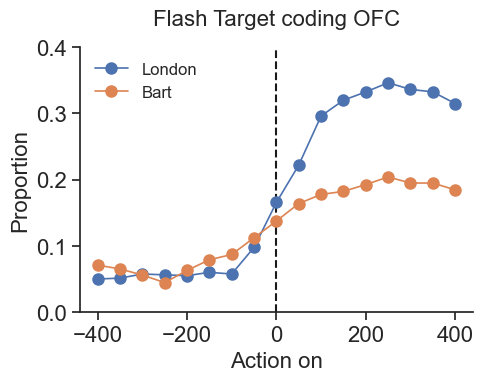

In [134]:
london_df = neuron_df[neuron_df.Animal=='London']
bart_df = neuron_df[neuron_df.Animal=='Bart']

plot_proportion((np.stack(london_df['spatial_ftest_pval'])<0.05),(np.stack(bart_df['spatial_ftest_pval'])<0.05),
                'Flash Target coding OFC',[0,0.4],['London','Bart'], save=1)

# plot_proportion((np.stack(london_df['spatial_ftest_pval'])<0.05) * (np.isin(np.stack(london_df['max_node_all']),[1,7,8,14])),
#                 (np.stack(bart_df['spatial_ftest_pval'])<0.05) * (np.isin(np.stack(bart_df['max_node_all']),[1,7,8,14])),
#                 'Navigation all steps, Target coding OFC',[0,0.4],['London','Bart'], save=1)

In [116]:
def plot_proportion(A,B,title,ylim,labels,save=0):
    
    plt.close('all')
    plt.figure(figsize=(5,4))
    timestamps = np.arange(-400,450,50)
    plt.plot(
            timestamps ,
            np.mean(A,axis=0),
            lw=1.2,
            marker='o',
            ms=8,
            label=labels[0],
            zorder=2
        )
    plt.plot(
            timestamps ,
            np.mean(B,axis=0),
            lw=1.2,
            marker='o',
            ms=8,
            label=labels[1],
            zorder=2
        )
    plt.axvline(0,color='k',ls='--',zorder=1)
    plt.legend(frameon=False)
    plt.title(title,y=1.05)
    plt.ylabel('Proportion')
    plt.xlabel('Action on')
    plt.ylim(ylim)
    plt.tight_layout()
    
    if save:
        plt.savefig(Path('D:/Figures/%s'%title))

In [64]:
def get_sig(whatinput, mode=[]):

    if mode=='cv':
        ts = np.argmax(whatinput.mean(axis=0))
        sig = whatinput[:,ts]
    else:
        ts = np.argmax(np.mean(whatinput<0.05,axis=0))
        sig = whatinput[:,ts]<0.05

    return ts, sig

In [15]:
# add regression results to neuron_df, navigation trials

neuron_df["coef"] = list(np.vstack(coef_all)) 
neuron_df["pval"] = list(np.vstack(pval_all))
neuron_df["max_node_all"] = list(np.vstack(ref_node_all))
neuron_df['spatial_ftest_pval'] = list(np.vstack(p_node_all))
neuron_df['generic_target_pval'] = list(np.vstack(generic_target_all))
neuron_df['generic_value_pval'] = list(np.vstack(generic_value_all))

_, neuron_df["value"] = get_sig(np.vstack(pval_all)[:,:,1])
ts, neuron_df['spatial_reg'] = get_sig(np.vstack(p_node_all))
neuron_df["max_node"] = list(np.vstack(ref_node_all)[:,ts])

sig_diff_node_all = np.sum(np.vstack(pval_all)[:,:,2:]<0.05,axis=2)
neuron_df["sig_diff_node_all"] = list(sig_diff_node_all)
neuron_df["sig_diff_node"] = list(sig_diff_node_all[:,ts])

_, neuron_df['generic_target'] = get_sig(np.sum(np.vstack(generic_target_all)<0.05,axis=2)>3,mode='cv')
_, neuron_df['generic_value'] = get_sig(np.sum(np.vstack(generic_value_all)<0.05,axis=2)>3,mode='cv')

os.chdir('D:\\SingleNeuron')
neuron_df.to_pickle("Tuning first step OFC.pkl")

In [32]:
neuron_df_first = pd.read_pickle("Tuning first step.pkl")

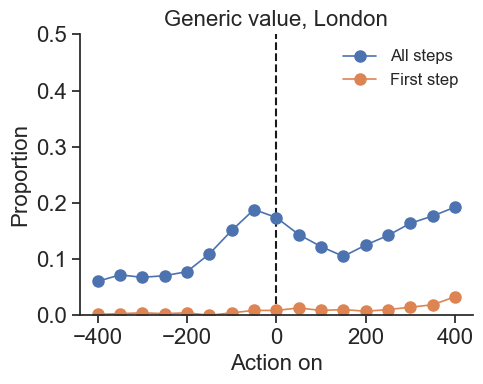

In [77]:
animal = 'London'
plot_proportion(np.sum(np.stack(neuron_df[neuron_df.Animal==animal]['generic_value_pval'])<0.05,axis=2)>3,
                np.sum(np.stack(neuron_df_first[neuron_df.Animal==animal]['generic_value_pval'])<0.05,axis=2)>3,
                'Generic value, %s'% animal)

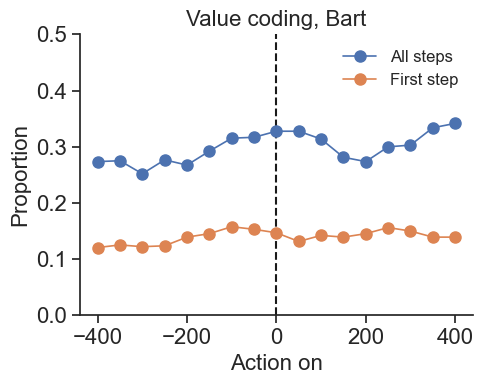

In [106]:
animal = 'Bart'
plot_proportion(np.stack(neuron_df[neuron_df.Animal==animal]['pval'])[:,:,1]<0.05,
                np.stack(neuron_df_first[neuron_df.Animal==animal]['pval'])[:,:,1]<0.05,
                'Value coding, %s'% animal, [0,0.5])

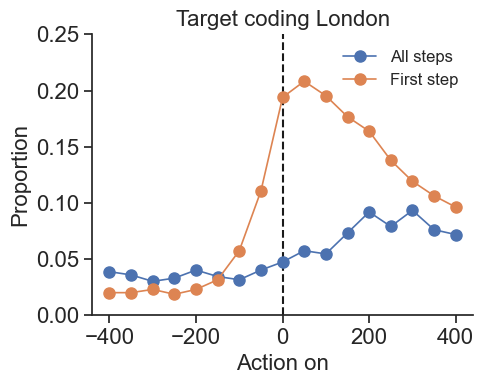

In [96]:
animal='London'
animal_df = neuron_df[neuron_df.Animal==animal]
animal_df_first = neuron_df_first[neuron_df_first.Animal==animal]

plot_proportion((np.stack(animal_df['spatial_ftest_pval'])<0.05) * (np.isin(np.stack(animal_df['max_node_all']),[1,7,8,14])),
                (np.stack(animal_df_first['spatial_ftest_pval'])<0.05) * (np.isin(np.stack(animal_df_first['max_node_all']),[1,7,8,14])),
                'Target coding %s' % animal,[0,0.25])

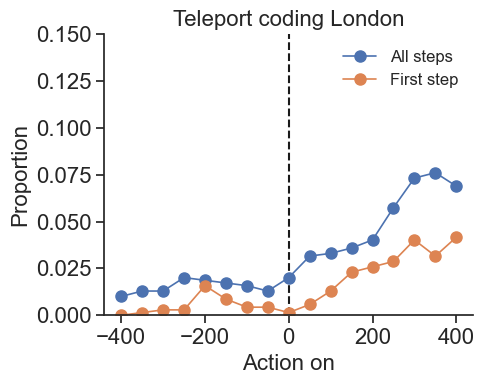

In [104]:
animal='London'
animal_df = neuron_df[neuron_df.Animal==animal]
animal_df_first = neuron_df_first[neuron_df_first.Animal==animal]

plot_proportion((np.stack(animal_df['spatial_ftest_pval'])<0.05) * (np.isin(np.stack(animal_df['max_node_all']),[0,15])),
                (np.stack(animal_df_first['spatial_ftest_pval'])<0.05) * (np.isin(np.stack(animal_df_first['max_node_all']),[0,15])),
                'Teleport coding %s' % animal,[0,0.15])

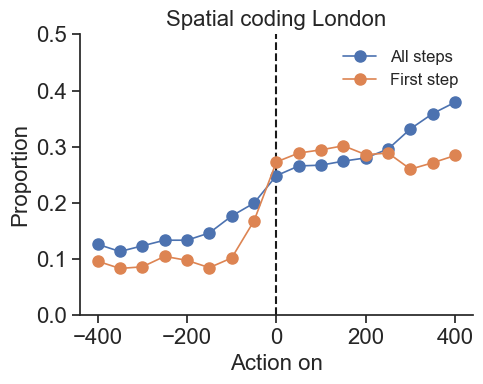

In [100]:
animal='London'
animal_df = neuron_df[neuron_df.Animal==animal]
animal_df_first = neuron_df_first[neuron_df_first.Animal==animal]

plot_proportion((np.stack(animal_df['spatial_ftest_pval'])<0.05),
                (np.stack(animal_df_first['spatial_ftest_pval'])<0.05),
                'Spatial coding %s' % animal,[0,0.5])

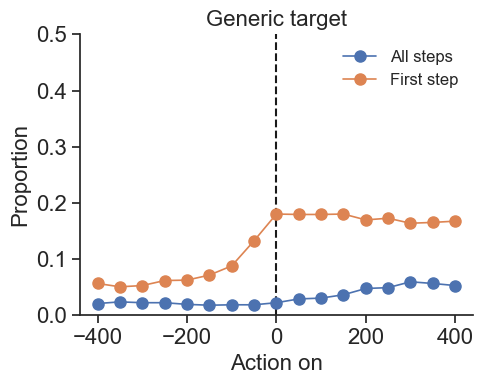

In [83]:
plot_proportion((np.sum(np.stack(neuron_df['generic_target_pval'])<0.05,axis=2)>3),
                np.sum(np.stack(neuron_df_first['generic_target_pval'])<0.05,axis=2)>3,
                'Generic target')

<Axes: xlabel='max_node', ylabel='Count'>

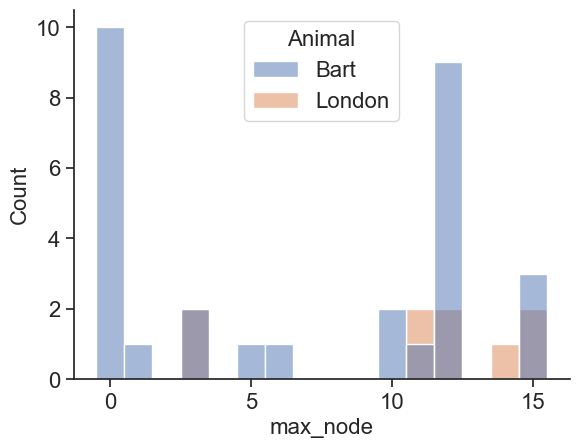

In [28]:
plt.close('all')
sns.histplot(data=neuron_df.query('(spatial_reg) & (sig_diff_node==15)'), x='max_node',bins=np.arange(-0.5,16),hue='Animal')

<Axes: xlabel='sig_diff_node', ylabel='Count'>

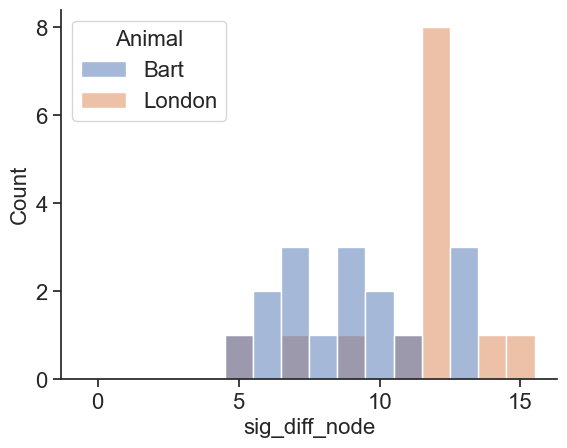

In [26]:
plt.close('all')
sns.histplot(data=neuron_df.query('spatial_reg & (max_node==14)'), x='sig_diff_node',bins=np.arange(-0.5,16),hue='Animal')

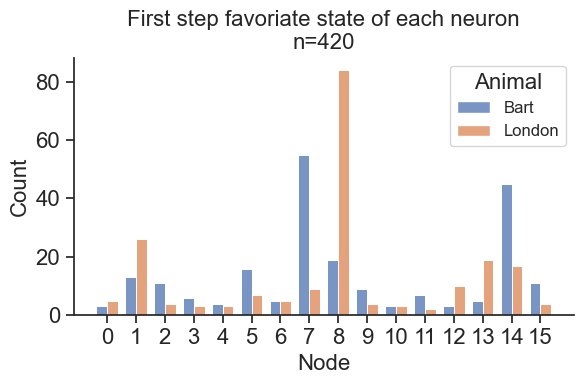

In [121]:
title = 'First step favoriate state of each neuron'

plt.close('all')
plt.figure(figsize=(6,4))
sns.histplot(data=neuron_df_first.query('spatial_reg'), x='max_node',bins=np.arange(-0.5,16),hue='Animal',multiple='dodge',shrink=0.75)
plt.xticks(np.arange(16))
plt.title(title+'\nn=%s' % int(neuron_df_first.spatial_reg.sum()))
plt.ylabel('Count')
plt.xlabel('Node')
plt.tight_layout()
plt.savefig('D:/SingleNeuron/'+title)